In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

from dataloader import *
from model import *
from util_sample import *
import os.path

### Load data:

In [2]:
directory = 'data/'
filename = 'coords.csv'
config = {}
config['seq_len'] = 60
config['batch_size'] = 64
config['overlap_rate'] = 0.0
config['coords'] = 3

dl = DataLoad(directory, filename)
dl.load_data(config['seq_len'], config['overlap_rate'], verbose = False)
dl.split_train_test(0.8)

data = dl.data
X_test = np.transpose(data['X_test'], [0,2,1])

max z is 458
31998 train samples and 8000 test samples


### Display some test data:

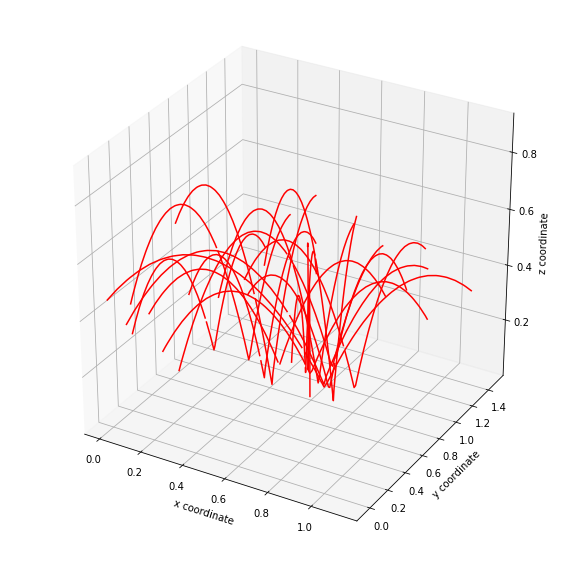

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(30):
    seq = X_test[i]
    ax.plot(seq[0,:], seq[1,:], seq[2,:],'r')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
plt.show()

### Load the pretrain model:

In [4]:
g = tf.Graph()
pretrained_graph_def = tf.GraphDef()
pretrained_graph_path = './data/export-graph.pb'

with open(pretrained_graph_path, 'rb') as f:
    pretrained_graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(pretrained_graph_def, name='')

Load some ops in the graph:

In [6]:
session = tf.Session()

placeholder_x = session.graph.get_tensor_by_name("Test/Model/Input_data:0")
initial_state_c_0 = session.graph.get_tensor_by_name("Test/Model/zeros:0")
initial_state_h_0 = session.graph.get_tensor_by_name("Test/Model/zeros_1:0")
initial_state_c_1 = session.graph.get_tensor_by_name("Test/Model/zeros_2:0")
initial_state_h_1 = session.graph.get_tensor_by_name("Test/Model/zeros_3:0")
initial_state = []
initial_state.append((initial_state_c_0, initial_state_h_0))
initial_state.append((initial_state_c_1, initial_state_h_1))
final_state_c_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/add_3:0")
final_state_h_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/mul_5:0")
final_state_c_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_1/lstm_cell/add_3:0")
final_state_h_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_1/lstm_cell/mul_5:0")
final_state = []
final_state.append((final_state_c_0, final_state_h_0))
final_state.append((final_state_c_1, final_state_h_1))
test_outputs = []
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:1"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:2"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_2:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_3:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Tanh:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Mul:0"))

### Sample some sequence with our model:

some parameters:

- predict_len: length of the sequence the model has to predict.
- sl_pre: number of data points you feed to the model before it predict.
- bias: a large bias will make the predicted trajectory less diversity.

In [7]:
sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], predict_len=120, sl_pre=30, bias=2.0)

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [64,3] vs. shape[1] = [20,64]
	 [[Node: Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/lstm_cell/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Test/Model/RNN/strided_slice, _recv_Test/Model/zeros_1_0/_11, Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/lstm_cell/concat/axis)]]
	 [[Node: Test/Model/MDN/Tanh/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_163_Test/Model/MDN/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/lstm_cell/concat', defined at:
  File "/home/jing/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/jing/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jing/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jing/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jing/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jing/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jing/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jing/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-0af809323fe0>", line 7, in <module>
    _ = tf.import_graph_def(pretrained_graph_def, name='')
  File "/home/jing/tensorflow-virtual/lib/python2.7/site-packages/tensorflow/python/framework/importer.py", line 287, in import_graph_def
    op_def=op_def)
  File "/home/jing/tensorflow-virtual/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jing/tensorflow-virtual/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): ConcatOp : Dimensions of inputs should match: shape[0] = [64,3] vs. shape[1] = [20,64]
	 [[Node: Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/lstm_cell/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Test/Model/RNN/strided_slice, _recv_Test/Model/zeros_1_0/_11, Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/lstm_cell/concat/axis)]]
	 [[Node: Test/Model/MDN/Tanh/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_163_Test/Model/MDN/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Predict with less data points fed:

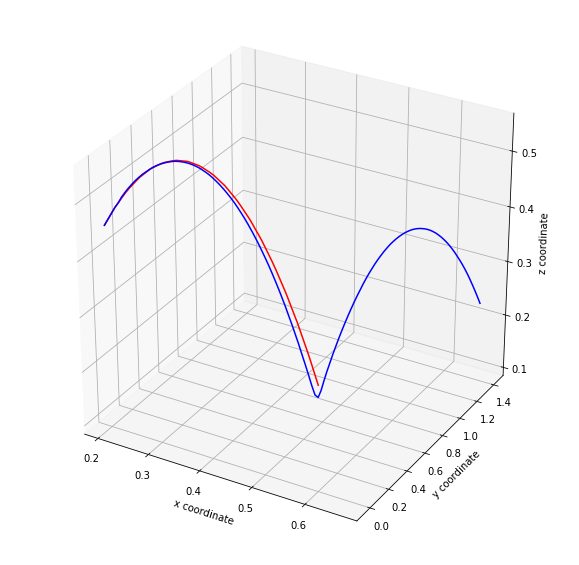

In [7]:
sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], predict_len=120, sl_pre=4, bias=2.0)